# Importing libraries

In [1]:
# import pyspark.sql module
from pyspark.sql import SparkSession

# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Spark Application') \
                    .getOrCreate()

# Importing Data

In [2]:
# import data
df = spark.read.csv('./data/creditcard.csv',
                         sep=',',
                         header=True)

# View the first five records
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [3]:
# Get number of records
print("The data contain %d records." % df.count())

The data contain 6362620 records.


In [4]:
# Get number of columns
print("The data contain %d columns." % len(df.columns))

The data contain 11 columns.


In [5]:
# Select randomly 1M records
df = df.sample(False, 0.5, 42)

# Data Pre-processing 

In [6]:
### Get count of nan or missing values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Observations:

This dataset is clean, no missing values.

In [7]:
# Schema of the data
df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [8]:
from pyspark.sql.types import DoubleType

df = df.withColumn("step", df.step.cast(DoubleType()))
df = df.withColumn("amount", df.amount.cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df.oldbalanceOrg.cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df.newbalanceOrig.cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df.oldbalanceDest.cast(DoubleType()))
df = df.withColumn("newbalanceDest", df.newbalanceDest.cast(DoubleType()))
df = df.withColumn("isFraud", df.isFraud.cast('int'))

In [9]:
# Check column data types
df.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'string')]

In [10]:
df = df.drop('isFlaggedFraud')

In [11]:
# Input variables : step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest
# Output Variable : isFraud

# EDA : Feature Engineering 

In [12]:
df.describe().show()

+-------+------------------+--------+------------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|    oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|
+-------+------------------+--------+------------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+
|  count|           3182505| 3182505|           3182505|    3182505|          3182505|           3182505|    3182505|           3182505|           3182505|             3182505|
|   mean|243.32051827098465|    null|180108.63530602978|       null|832749.6707201254| 853986.0712083996|       null|1104812.3688028697|1229522.0882875763|0.001285779598146743|
| stddev| 142.3514799023828|    null| 603080.4075271396|       null|2884824.170356285|2920635.8624181743|       nul

In [13]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double' or t[1]=='int']
df.select(numeric_features).describe().toPandas()

,summary,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,count,3182505,3182505,3182505,3182505,3182505,3182505,3182505
1,mean,243.32051827098465,180108.63530602978,832749.6707201254,853986.0712083996,1104812.3688028697,1229522.0882875763,0.001285779598146743
2,stddev,142.3514799023828,603080.4075271396,2884824.170356285,2920635.8624181743,3427265.1766493297,3700988.0592913437,0.035834714627960236
3,min,1.0,0.0,0.0,0.0,0.0,0.0,0
4,max,743.0,9.244551664E7,5.958504037E7,4.958504037E7,3.5538143361E8,3.555534163E8,1


In [14]:
df.groupBy("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   4092|
|      0|3178413|
+-------+-------+



In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
pd_df = df.toPandas()
print('Distribution of the Classes in the dataset')
print(pd_df['isFraud'].value_counts()/len(pd_df))

Distribution of the Classes in the dataset
0    0.998714
1    0.001286
Name: isFraud, dtype: float64


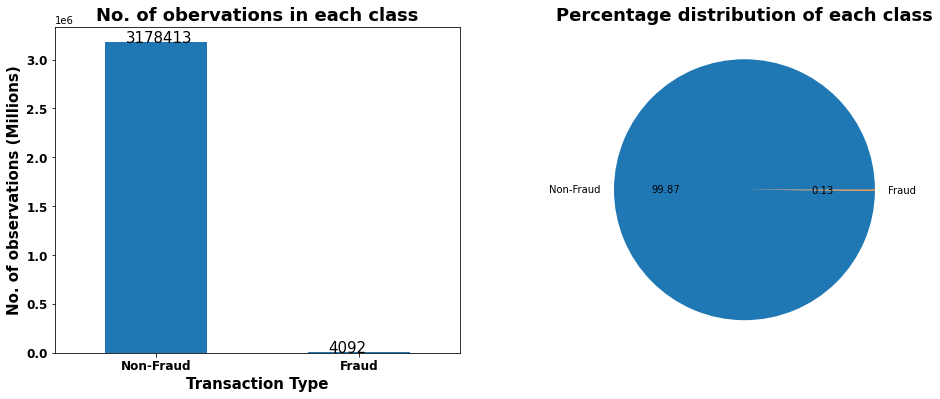

In [16]:
plt.subplots(1,2, figsize=(16,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = pd_df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each class', fontsize=18, fontweight='bold')
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(pd_df['isFraud'].value_counts(), labels=['Non-Fraud','Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each class', fontsize=18, fontweight='bold')

# display plot
plt.show()

### Observations:

Fraudulent transaction observations are only 8,213 (0.13%). Fraud is rare.

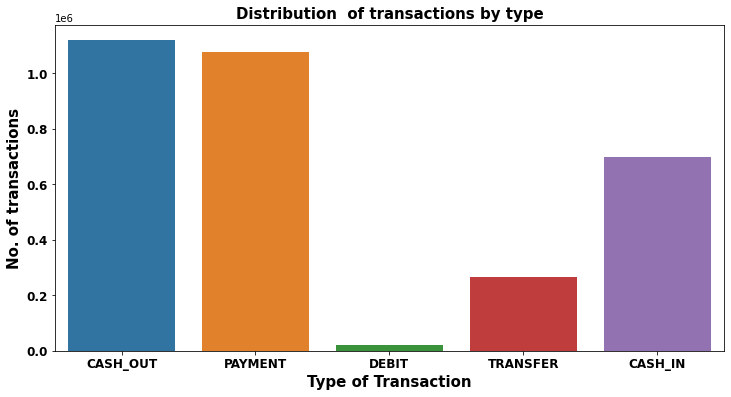

In [17]:
plt.subplots(figsize=(12,6))
sns.countplot('type', data=pd_df)
plt.xlabel('Type of Transaction', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Distribution  of transactions by type', fontsize=15, fontweight='bold')
plt.show()

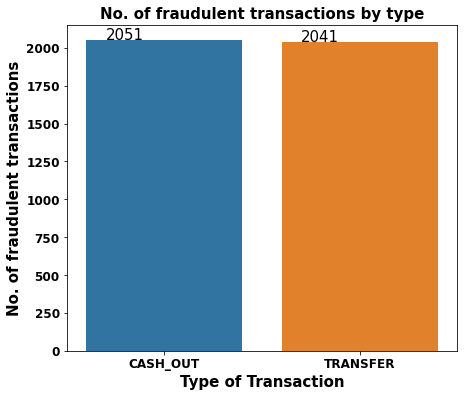

In [18]:
plt.subplots(figsize=(7,6))
fr_df = pd_df[pd_df['isFraud'] == 1]
ax =sns.countplot('type', data=fr_df)
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')
plt.xlabel('Type of Transaction', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of fraudulent transactions by type', fontsize=15, fontweight='bold')
plt.show()

In [19]:
print(fr_df['type'].value_counts()/len(fr_df))

CASH_OUT    0.501222
TRANSFER    0.498778
Name: type, dtype: float64


Nous pouvons observer que les transactions frauduleuses sont uniquement des retraits (cash_out) et des virements (transfer) avec des taux de fraude de 0.5% pour chacun d'entre eux.

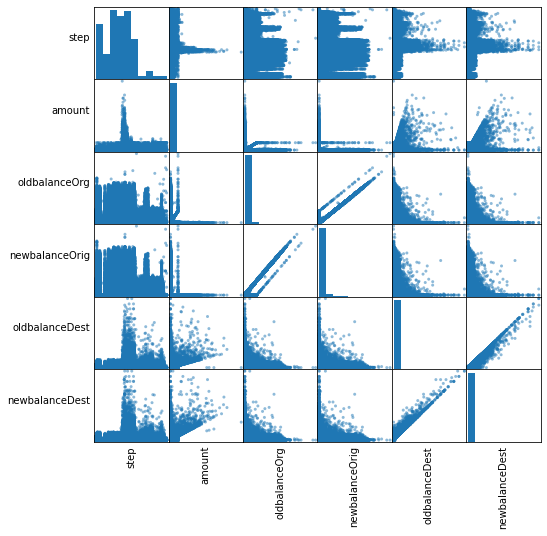

In [20]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = ['step', 'amount', 'oldbalanceOrg',
                    'newbalanceOrig','oldbalanceDest', 
                    'newbalanceDest']

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

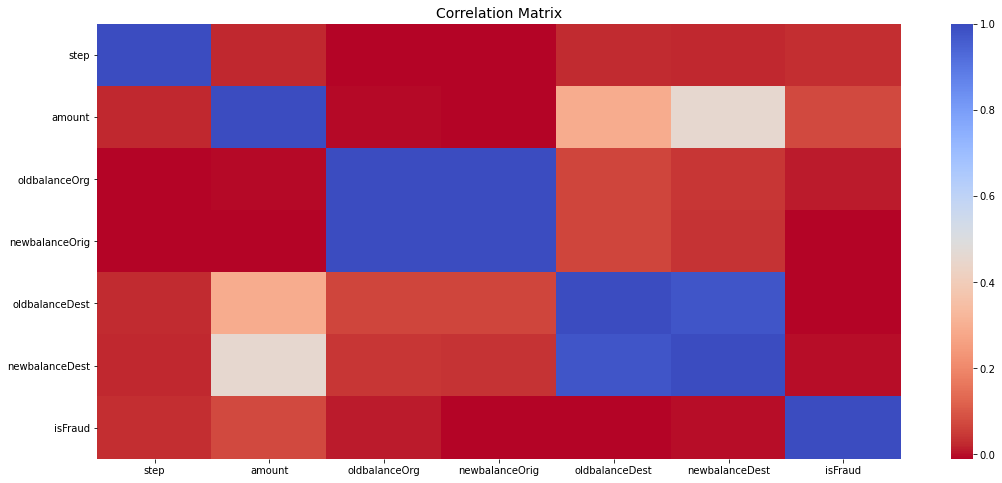

In [21]:
# we can check the important parameters that could effect our model.
f, ax = plt.subplots(figsize=(18,8))

sub_sample_corr = pd_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14)
plt.show()

Il n'y a pas de corrélations visibles entre les variables.

# Data Pre-processing :

In [22]:
data = df

In [23]:
data.show(5)

+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
|step|    type| amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+
| 1.0|CASH_OUT|  181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|
| 1.0| PAYMENT|7861.64|C1912850431|    176087.23|     168225.59| M633326333|           0.0|           0.0|      0|
| 1.0|   DEBIT|9644.94|C1900366749|       4465.0|           0.0| C997608398|       10845.0|     157982.12|      0|
| 1.0| PAYMENT|2560.74|C1648232591|       5070.0|       2509.26| M972865270|           0.0|           0.0|      0|
| 1.0| PAYMENT|1563.82| C761750706|        450.0|           0.0|M1731217984|           0.0|           0.0|      0|
+----+--------+-------+-----------+-------------+--------------+-----------+----

In [24]:
data['type', 'nameOrig', 'nameDest'].show(5)

+--------+-----------+-----------+
|    type|   nameOrig|   nameDest|
+--------+-----------+-----------+
|CASH_OUT| C840083671|  C38997010|
| PAYMENT|C1912850431| M633326333|
|   DEBIT|C1900366749| C997608398|
| PAYMENT|C1648232591| M972865270|
| PAYMENT| C761750706|M1731217984|
+--------+-----------+-----------+
only showing top 5 rows



## separate nameOrig and nameDest :

In [25]:
import pyspark.sql.functions as F

data = (
    data.withColumn('str_orig', F.substring('nameOrig', 1,1))
    .withColumn('num_orig', F.col('nameOrig').substr(F.lit(2), F.length('nameOrig') - F.lit(1)))
)
data = data.drop('nameOrig')
# show df
data.show(5)

+----+--------+-------+-------------+--------------+-----------+--------------+--------------+-------+--------+----------+
|step|    type| amount|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|str_orig|  num_orig|
+----+--------+-------+-------------+--------------+-----------+--------------+--------------+-------+--------+----------+
| 1.0|CASH_OUT|  181.0|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|       C| 840083671|
| 1.0| PAYMENT|7861.64|    176087.23|     168225.59| M633326333|           0.0|           0.0|      0|       C|1912850431|
| 1.0|   DEBIT|9644.94|       4465.0|           0.0| C997608398|       10845.0|     157982.12|      0|       C|1900366749|
| 1.0| PAYMENT|2560.74|       5070.0|       2509.26| M972865270|           0.0|           0.0|      0|       C|1648232591|
| 1.0| PAYMENT|1563.82|        450.0|           0.0|M1731217984|           0.0|           0.0|      0|       C| 761750706|
+----+--------+-

In [26]:
data = data.withColumn("num_orig", data.num_orig.cast(DoubleType()))

In [27]:
import pyspark.sql.functions as F

data = (
    data.withColumn('str_dest', F.substring('nameDest', 1,1))
    .withColumn('num_dest', F.col('nameDest').substr(F.lit(2), F.length('nameDest') - F.lit(1)))
)
data = data.drop('nameDest')
# show df
data.show(5)

+----+--------+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+----------+
|step|    type| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|str_orig|     num_orig|str_dest|  num_dest|
+----+--------+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+----------+
| 1.0|CASH_OUT|  181.0|        181.0|           0.0|       21182.0|           0.0|      1|       C| 8.40083671E8|       C|  38997010|
| 1.0| PAYMENT|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|       C|1.912850431E9|       M| 633326333|
| 1.0|   DEBIT|9644.94|       4465.0|           0.0|       10845.0|     157982.12|      0|       C|1.900366749E9|       C| 997608398|
| 1.0| PAYMENT|2560.74|       5070.0|       2509.26|           0.0|           0.0|      0|       C|1.648232591E9|       M| 972865270|
| 1.0| PAYMENT|1563.82|        450.0|           0.0|          

In [28]:
data = data.withColumn("num_dest", data.num_orig.cast(DoubleType()))

In [29]:
data.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('str_orig', 'string'),
 ('num_orig', 'double'),
 ('str_dest', 'string'),
 ('num_dest', 'double')]

## Apply OneHotEncoder to type, str_orig and str_dest columns

### type column :

In [30]:
from pyspark.ml.feature import StringIndexer
type_indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
#Fits a model to the input dataset with optional parameters.
data = type_indexer.fit(data).transform(data)
data = data.drop('type')
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+-------------+---------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|str_orig|     num_orig|str_dest|     num_dest|typeIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+--------+-------------+--------+-------------+---------+
| 1.0|  181.0|        181.0|           0.0|       21182.0|           0.0|      1|       C| 8.40083671E8|       C| 8.40083671E8|      0.0|
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|       C|1.912850431E9|       M|1.912850431E9|      1.0|
| 1.0|9644.94|       4465.0|           0.0|       10845.0|     157982.12|      0|       C|1.900366749E9|       C|1.900366749E9|      4.0|
| 1.0|2560.74|       5070.0|       2509.26|           0.0|           0.0|      0|       C|1.648232591E9|       M|1.648232591E9|      1.0|
| 1.0|1563.82|        450.0|      

In [31]:
data.groupBy("typeIndex").count().show()

+---------+-------+
|typeIndex|  count|
+---------+-------+
|      0.0|1119800|
|      1.0|1075637|
|      4.0|  20621|
|      3.0| 266850|
|      2.0| 699597|
+---------+-------+



### str_orig column :

In [32]:
nameOrig_indexer = StringIndexer(inputCol="str_orig", outputCol="nameOrigIndex")
#Fits a model to the input dataset with optional parameters.
data = nameOrig_indexer.fit(data).transform(data).drop('str_orig')
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+-------------+--------+-------------+---------+-------------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|str_dest|     num_dest|typeIndex|nameOrigIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+-------------+--------+-------------+---------+-------------+
| 1.0|  181.0|        181.0|           0.0|       21182.0|           0.0|      1| 8.40083671E8|       C| 8.40083671E8|      0.0|          0.0|
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|1.912850431E9|       M|1.912850431E9|      1.0|          0.0|
| 1.0|9644.94|       4465.0|           0.0|       10845.0|     157982.12|      0|1.900366749E9|       C|1.900366749E9|      4.0|          0.0|
| 1.0|2560.74|       5070.0|       2509.26|           0.0|           0.0|      0|1.648232591E9|       M|1.648232591E9|      1.0|          0.0|

### str_dest column :

In [33]:
nameDest_indexer = StringIndexer(inputCol="str_dest", outputCol="nameDestIndex")
#Fits a model to the input dataset with optional parameters.
data = nameDest_indexer.fit(data).transform(data).drop('str_dest')
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|     num_dest|typeIndex|nameOrigIndex|nameDestIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
| 1.0|  181.0|        181.0|           0.0|       21182.0|           0.0|      1| 8.40083671E8| 8.40083671E8|      0.0|          0.0|          0.0|
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|1.912850431E9|1.912850431E9|      1.0|          0.0|          1.0|
| 1.0|9644.94|       4465.0|           0.0|       10845.0|     157982.12|      0|1.900366749E9|1.900366749E9|      4.0|          0.0|          0.0|
| 1.0|2560.74|       5070.0|       2509.26|           0.0|           0.0|      0|1.648232591E9|1.648232591E9|   

In [34]:
data.dtypes

[('step', 'double'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('num_orig', 'double'),
 ('num_dest', 'double'),
 ('typeIndex', 'double'),
 ('nameOrigIndex', 'double'),
 ('nameDestIndex', 'double')]

In [35]:
data.show(5)

+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|     num_orig|     num_dest|typeIndex|nameOrigIndex|nameDestIndex|
+----+-------+-------------+--------------+--------------+--------------+-------+-------------+-------------+---------+-------------+-------------+
| 1.0|  181.0|        181.0|           0.0|       21182.0|           0.0|      1| 8.40083671E8| 8.40083671E8|      0.0|          0.0|          0.0|
| 1.0|7861.64|    176087.23|     168225.59|           0.0|           0.0|      0|1.912850431E9|1.912850431E9|      1.0|          0.0|          1.0|
| 1.0|9644.94|       4465.0|           0.0|       10845.0|     157982.12|      0|1.900366749E9|1.900366749E9|      4.0|          0.0|          0.0|
| 1.0|2560.74|       5070.0|       2509.26|           0.0|           0.0|      0|1.648232591E9|1.648232591E9|   

In [36]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                                       'newbalanceDest', 'num_orig', 'num_dest', 'typeIndex','nameOrigIndex',
                                       'nameDestIndex'], outputCol='features')
data = assembler.transform(data)

In [37]:
data['features','isFraud'].show(5)

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|(10,[0,1,3,5,6],[...|      1|
|[7861.64,176087.2...|      0|
|[9644.94,4465.0,0...|      0|
|[2560.74,5070.0,2...|      0|
|[1563.82,450.0,0....|      0|
+--------------------+-------+
only showing top 5 rows



### Split the data to training sets and test sets :

In [38]:
(train, test )= data.randomSplit([0.8, 0.2], seed=23)

In [39]:
[train.count(), test.count()]

[2544735, 637770]

# Logistic Regression :

In [88]:
from pyspark.ml.classification import LogisticRegression
#Create a Logistic Regression classifier.
logistic = LogisticRegression(labelCol = "isFraud", featuresCol = "features")
# Learn from the training data.
lrModel = logistic.fit(train)

In [89]:
prediction_LR = lrModel.transform(test)

In [90]:
prediction_LR.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   459|
|      0|       0.0|636923|
|      1|       1.0|   346|
|      0|       1.0|    42|
+-------+----------+------+



In [91]:
tp = prediction_LR[(prediction_LR.isFraud == 1) & (prediction_LR.prediction == 1)].count()
tn = prediction_LR[(prediction_LR.isFraud == 0) & (prediction_LR.prediction == 0)].count()
fp = prediction_LR[(prediction_LR.isFraud == 0) & (prediction_LR.prediction == 1)].count()
fn = prediction_LR[(prediction_LR.isFraud == 1) & (prediction_LR.prediction == 0)].count()
recall_LR = tp/(tp+fn)
precision_LR = tp/(tp+fp)
f1_score_LR = 2*(recall_LR*precision_LR)/(recall_LR+precision_LR)
print("Recall : ",recall_LR)
print("Precision : ", precision_LR)
print("F1 Score : ", f1_score_LR)

Recall :  0.4298136645962733
Precision :  0.8917525773195877
F1 Score :  0.5800502933780386


In [92]:
# Area under ROC curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
areaUnderROC_LR = evaluator.evaluate(prediction_LR, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_LR)

Area under ROC = 0.9878424845929653


In [93]:
# Area under precision-recall curve
areaUnderPR_LR = evaluator.evaluate(prediction_LR, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_LR)

Area under PR = 0.47870897117876576


In [94]:
results = {}

In [95]:
results['Logestic Regression'] = [recall_LR, precision_LR, f1_score_LR, areaUnderROC_LR, areaUnderPR_LR]

In [96]:
results

{'Logestic Regression': [0.4298136645962733,
  0.8917525773195877,
  0.5800502933780386,
  0.9878424845929653,
  0.47870897117876576]}

# Decision Tree Classifier :

In [97]:
from pyspark.ml.classification import DecisionTreeClassifier

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "isFraud", featuresCol = "features", seed = 54321, maxDepth = 5)

dt_model = dt.fit(train)

In [98]:
# Make predictions.
prediction_DT = dt_model.transform(test)

In [99]:
# Select example rows to display.
prediction_DT.select('features', 'rawPrediction', 'probability', 'prediction').show(5)

+--------------------+---------------+-----------+----------+
|            features|  rawPrediction|probability|prediction|
+--------------------+---------------+-----------+----------+
|[23.31,45360.0,45...|[1434936.0,0.0]|  [1.0,0.0]|       0.0|
|(10,[0,5,6,7,9],[...|[1434936.0,0.0]|  [1.0,0.0]|       0.0|
|[112.56,609035.85...|[1434936.0,0.0]|  [1.0,0.0]|       0.0|
|[154.87,9339.0,91...|[1434936.0,0.0]|  [1.0,0.0]|       0.0|
|[339.82,12076.0,1...|[1434936.0,0.0]|  [1.0,0.0]|       0.0|
+--------------------+---------------+-----------+----------+
only showing top 5 rows



In [100]:
prediction_DT.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   275|
|      0|       0.0|636934|
|      1|       1.0|   530|
|      0|       1.0|    31|
+-------+----------+------+



In [101]:
tp = prediction_DT[(prediction_DT.isFraud == 1) & (prediction_DT.prediction == 1)].count()
tn = prediction_DT[(prediction_DT.isFraud == 0) & (prediction_DT.prediction == 0)].count()
fp = prediction_DT[(prediction_DT.isFraud == 0) & (prediction_DT.prediction == 1)].count()
fn = prediction_DT[(prediction_DT.isFraud == 1) & (prediction_DT.prediction == 0)].count()
recall_DT = tp/(tp+fn)
precision_DT = tp/(tp+fp)
f1_score_DT = 2*(recall_DT*precision_DT)/(recall_DT+precision_DT)
print("Recall : ",recall_DT)
print("Precision : ", precision_DT)
print("F1 Score : ", f1_score_DT)

Recall :  0.6583850931677019
Precision :  0.9447415329768271
F1 Score :  0.7759882869692533


In [102]:
# Area under ROC curve
areaUnderROC_DT = evaluator.evaluate(prediction_DT, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_DT)

Area under ROC = 0.7885420111180382


In [103]:
# Area under precision-recall curve
areaUnderPR_DT = evaluator.evaluate(prediction_DT, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_DT)

Area under PR = 0.43917590355501346


In [104]:
results['Decision Tree Classifier'] = [recall_DT, precision_DT, f1_score_DT, areaUnderROC_DT, areaUnderPR_DT]
results

{'Logestic Regression': [0.4298136645962733,
  0.8917525773195877,
  0.5800502933780386,
  0.9878424845929653,
  0.47870897117876576],
 'Decision Tree Classifier': [0.6583850931677019,
  0.9447415329768271,
  0.7759882869692533,
  0.7885420111180382,
  0.43917590355501346]}

# Random Forest Classifier :

In [105]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=10)

rf_model = rf.fit(train)

In [106]:
# Make predictions.
prediction_RF = rf_model.transform(test)

In [107]:
prediction_RF.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   450|
|      0|       0.0|636965|
|      1|       1.0|   355|
+-------+----------+------+



In [108]:
tp = prediction_RF[(prediction_RF.isFraud == 1) & (prediction_RF.prediction == 1)].count()
tn = prediction_RF[(prediction_RF.isFraud == 0) & (prediction_RF.prediction == 0)].count()
fp = prediction_RF[(prediction_RF.isFraud == 0) & (prediction_RF.prediction == 1)].count()
fn = prediction_RF[(prediction_RF.isFraud == 1) & (prediction_RF.prediction == 0)].count()
recall_RF = tp/(tp+fn)
precision_RF = tp/(tp+fp)
f1_score_RF = 2*(recall_RF*precision_RF)/(recall_RF+precision_RF)
print("Recall : ",recall_RF)
print("Precision : ", precision_RF)
print("F1 Score : ", f1_score_RF)

Recall :  0.4409937888198758
Precision :  1.0
F1 Score :  0.6120689655172413


In [109]:
# Area under ROC curve
areaUnderROC_RF = evaluator.evaluate(prediction_RF, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_RF)

Area under ROC = 0.9833062075770519


In [110]:
# Area under precision-recall curve
areaUnderPR_RF = evaluator.evaluate(prediction_RF, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_RF)

Area under PR = 0.7391443041027936


In [111]:
results['Random Forest Classifier'] = [recall_RF, precision_RF, f1_score_RF, areaUnderROC_RF, areaUnderPR_RF]
results

{'Logestic Regression': [0.4298136645962733,
  0.8917525773195877,
  0.5800502933780386,
  0.9878424845929653,
  0.47870897117876576],
 'Decision Tree Classifier': [0.6583850931677019,
  0.9447415329768271,
  0.7759882869692533,
  0.7885420111180382,
  0.43917590355501346],
 'Random Forest Classifier': [0.4409937888198758,
  1.0,
  0.6120689655172413,
  0.9833062075770519,
  0.7391443041027936]}

# Gradient-Boosted Tree Classifier

In [112]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)

# Train model. 
gbt_model = gbt.fit(train)

In [113]:
# Make predictions.
prediction_GBT = gbt_model.transform(test)

In [114]:
prediction_GBT.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   269|
|      0|       0.0|636955|
|      1|       1.0|   536|
|      0|       1.0|    10|
+-------+----------+------+



In [115]:
tp = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 1)].count()
tn = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 0)].count()
fp = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 1)].count()
fn = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 0)].count()
recall_GBT = tp/(tp+fn)
precision_GBT = tp/(tp+fp)
f1_score_GBT = 2*(recall_GBT*precision_GBT)/(recall_GBT+precision_GBT)
print("Recall : ",recall_GBT)
print("Precision : ", precision_GBT)
print("F1 Score : ", f1_score_GBT)

Recall :  0.6658385093167701
Precision :  0.9816849816849816
F1 Score :  0.7934863064396743


In [116]:
# Area under ROC curve
areaUnderROC_GBT = evaluator.evaluate(prediction_GBT, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_GBT)

Area under ROC = 0.9933988825989785


In [117]:
# Area under precision-recall curve
areaUnderPR_GBT = evaluator.evaluate(prediction_GBT, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_GBT)

Area under PR = 0.7939337799337051


In [118]:
results['Gradient-Boosted Tree Classifier'] = [recall_GBT, precision_GBT, f1_score_GBT, areaUnderROC_GBT, areaUnderPR_GBT]
results

{'Logestic Regression': [0.4298136645962733,
  0.8917525773195877,
  0.5800502933780386,
  0.9878424845929653,
  0.47870897117876576],
 'Decision Tree Classifier': [0.6583850931677019,
  0.9447415329768271,
  0.7759882869692533,
  0.7885420111180382,
  0.43917590355501346],
 'Random Forest Classifier': [0.4409937888198758,
  1.0,
  0.6120689655172413,
  0.9833062075770519,
  0.7391443041027936],
 'Gradient-Boosted Tree Classifier': [0.6658385093167701,
  0.9816849816849816,
  0.7934863064396743,
  0.9933988825989785,
  0.7939337799337051]}

# Naive Bayes

In [119]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(labelCol="isFraud", featuresCol="features", smoothing=1.0, modelType="multinomial")

# train the model
nb_model = nb.fit(train)

In [120]:
# Make predictions.
prediction_NB = nb_model.transform(test)

In [121]:
prediction_NB.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   358|
|      0|       0.0|597681|
|      1|       1.0|   447|
|      0|       1.0| 39284|
+-------+----------+------+



In [122]:
tp = prediction_NB[(prediction_NB.isFraud == 1) & (prediction_NB.prediction == 1)].count()
tn = prediction_NB[(prediction_NB.isFraud == 0) & (prediction_NB.prediction == 0)].count()
fp = prediction_NB[(prediction_NB.isFraud == 0) & (prediction_NB.prediction == 1)].count()
fn = prediction_NB[(prediction_NB.isFraud == 1) & (prediction_NB.prediction == 0)].count()
recall_NB = tp/(tp+fn)
precision_NB = tp/(tp+fp)
f1_score_NB = 2*(recall_NB*precision_NB)/(recall_NB+precision_NB)
print("Recall : ",recall_NB)
print("Precision : ", precision_NB)
print("F1 Score : ", f1_score_NB)

Recall :  0.55527950310559
Precision :  0.011250660693161512
F1 Score :  0.022054470100651275


In [123]:
# Area under ROC curve
areaUnderROC_NB = evaluator.evaluate(prediction_NB, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_NB)

Area under ROC = 0.5065029071041619


In [124]:
# Area under precision-recall curve
areaUnderPR_NB = evaluator.evaluate(prediction_NB, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_NB)

Area under PR = 0.0012761425887956698


In [125]:
results['Naive Bayes'] = [recall_NB, precision_NB, f1_score_NB, areaUnderROC_NB, areaUnderPR_NB]
results

{'Logestic Regression': [0.4298136645962733,
  0.8917525773195877,
  0.5800502933780386,
  0.9878424845929653,
  0.47870897117876576],
 'Decision Tree Classifier': [0.6583850931677019,
  0.9447415329768271,
  0.7759882869692533,
  0.7885420111180382,
  0.43917590355501346],
 'Random Forest Classifier': [0.4409937888198758,
  1.0,
  0.6120689655172413,
  0.9833062075770519,
  0.7391443041027936],
 'Gradient-Boosted Tree Classifier': [0.6658385093167701,
  0.9816849816849816,
  0.7934863064396743,
  0.9933988825989785,
  0.7939337799337051],
 'Naive Bayes': [0.55527950310559,
  0.011250660693161512,
  0.022054470100651275,
  0.5065029071041619,
  0.0012761425887956698]}

In [126]:
results = pd.DataFrame.from_dict(results, orient='index',
                       columns=['Recall', 'Precision', 'F1 Score', 'Area Under ROC', 'Area Under PR'])

In [127]:
results

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709
Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276


In [37]:
results.to_csv ('results.csv')
df = pd.read_csv('results.csv')
df

,Unnamed: 0,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
0,Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709
1,Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
2,Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
3,Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
4,Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276


In [38]:
df.sort_values(["Recall"], ascending=False)

,Unnamed: 0,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
3,Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
1,Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
4,Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276
2,Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
0,Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709


In [39]:
df.sort_values(["Precision"], ascending=False)

,Unnamed: 0,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
2,Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
3,Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
1,Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
0,Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709
4,Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276


In [40]:
df.sort_values(["F1 Score"], ascending=False)

,Unnamed: 0,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
3,Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
1,Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
2,Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
0,Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709
4,Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276


In [41]:
df.sort_values(["Area Under ROC"], ascending=False)

,Unnamed: 0,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
3,Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
0,Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709
2,Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
1,Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
4,Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276


In [42]:
df.sort_values(["Area Under PR"], ascending=False)

,Unnamed: 0,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
3,Gradient-Boosted Tree Classifier,0.665839,0.981685,0.793486,0.993399,0.793934
2,Random Forest Classifier,0.440994,1.000000,0.612069,0.983306,0.739144
0,Logestic Regression,0.429814,0.891753,0.580050,0.987842,0.478709
1,Decision Tree Classifier,0.658385,0.944742,0.775988,0.788542,0.439176
4,Naive Bayes,0.555280,0.011251,0.022054,0.506503,0.001276
